In [3]:
gpt2_data <- read.csv("data/surprisal_data/gpt2_surprisal_rts.csv")

In [4]:
dundee_gpt <- gpt2_data[gpt2_data$corpus == "dundee",]
natural_stories_gpt <- gpt2_data[gpt2_data$corpus == "natural_stories",]

In [6]:
et_control_formula <- 'rt ~ log_freq * word_length + prev_freq_1 * prev_len_1'
et_surprisal_formula <- 'rt ~ surprisal + prev_surprisal_1 + log_freq * word_length + prev_freq_1 * prev_len_1'

spr_control_formula <- 'rt ~ log_freq * word_length + prev_freq_1 * prev_len_1 + prev_freq_2 * prev_len_2 + prev_freq_3 * prev_len_3'
spr_surprisal_formula <- 'rt ~ surprisal + prev_surprisal_1 + prev_surprisal_2 + prev_surprisal_3 + log_freq * word_length + prev_freq_1 * prev_len_1 + prev_freq_2 * prev_len_2 + prev_freq_3 * prev_len_3'

In [7]:
predictive_power <- function(data, control_formula, surprisal_formula, tokenization, log_values) {
    control_model <- glm(control_formula, data, family = 'gaussian')
    surprisal_model <- glm(surprisal_formula, data, family = 'gaussian')
    if (log_values) {
        print(tokenization)
        print(summary(surprisal_model)$coefficients)
    }
    (logLik(surprisal_model) - logLik(control_model)) / nrow(data)
}

In [8]:
predictive_power(dundee_gpt, et_control_formula, et_surprisal_formula, "bpe", TRUE)

[1] "bpe"
                          Estimate Std. Error    t value     Pr(>|t|)
(Intercept)            220.2726663 4.25017300  51.826753 0.000000e+00
surprisal                1.8340967 0.09499248  19.307809 1.201773e-82
prev_surprisal_1         0.8558745 0.09024642   9.483750 2.596678e-21
log_freq                 5.5268917 0.95210122   5.804941 6.492396e-09
word_length             -0.7408914 0.69248186  -1.069907 2.846681e-01
prev_freq_1              2.4640931 0.95458146   2.581333 9.845835e-03
prev_len_1              -8.8410591 0.70087316 -12.614350 2.099166e-36
log_freq:word_length    -2.7657004 0.16713078 -16.548122 2.772926e-61
prev_freq_1:prev_len_1  -1.1447509 0.16959805  -6.749788 1.502861e-11


'log Lik.' 0.006696996 (df=10)

In [9]:
predictive_power(natural_stories_gpt, spr_control_formula, spr_surprisal_formula, "bpe", TRUE)

[1] "bpe"
                           Estimate Std. Error    t value     Pr(>|t|)
(Intercept)            317.67153186 6.89744827 46.0563848 0.000000e+00
surprisal                1.03500218 0.09937174 10.4154583 3.356685e-25
prev_surprisal_1         0.45831894 0.09285295  4.9359651 8.178487e-07
prev_surprisal_2         0.12933909 0.08762222  1.4760992 1.399667e-01
prev_surprisal_3         0.07842217 0.08743729  0.8968962 3.698082e-01
log_freq                 3.70192901 0.99005608  3.7391104 1.862929e-04
word_length             -3.88473964 0.78228422 -4.9658929 7.016736e-07
prev_freq_1              0.71545150 1.02279355  0.6995072 4.842606e-01
prev_len_1              -2.24576078 0.80689800 -2.7832028 5.398384e-03
prev_freq_2             -0.75211580 0.98009692 -0.7673892 4.428786e-01
prev_len_2               0.14034742 0.79757645  0.1759674 8.603252e-01
prev_freq_3              0.41829672 0.95890954  0.4362213 6.626910e-01
prev_len_3              -0.91624883 0.78640404 -1.1651121 2.440173e

'log Lik.' 0.01084273 (df=18)

In [10]:
test_data_loglik <- function(model, test_data) {
    predictions <- predict(model, test_data)
    stdev <- sigma(model)
    dnorm(test_data$rt, predictions, stdev, log = TRUE)
}

cross_validate <- function(data, indices, control_formula, surprisal_formula) {
    data<-data[indices,]
    folds <- cut(seq(1,nrow(data)),breaks=10,labels=FALSE) # this is the same for each model
    predictive_power <- seq(1:10)
    for(i in 1:10){
        test_indices <- which(folds==i)
        test_data <- data[test_indices, ]
        train_data <- data[-test_indices, ]
        fold_control_model <- glm(control_formula, train_data, family = 'gaussian')
        fold_surprisal_model <- glm(surprisal_formula, train_data, family = 'gaussian')
        surprisal_diff <- test_data_loglik(fold_surprisal_model, test_data) - test_data_loglik(fold_control_model, test_data)
        predictive_power[i] <- mean(surprisal_diff) # summed per-token log likelihoods, divided by number of tokens 
        }
    predictive_power
}

In [33]:
dundee_shuffled <- sample(nrow(dundee_gpt))
ns_shuffled <- sample(nrow(natural_stories_gpt))
cv_results <- data.frame(dundee = cross_validate(dundee_gpt, dundee_shuffled, et_control_formula, et_surprisal_formula),
natural_stories = cross_validate(natural_stories_gpt, ns_shuffled, spr_control_formula, spr_surprisal_formula)
)

In [17]:
library(ggplot2)
library(reshape2)
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [34]:
cv_results <- melt(cv_results)

No id variables; using all as measure variables

Warning message in eval(f):
"Incompatible methods ("Ops.factor", "Ops.quosure") for "+""


ERROR: Error in FUN(left, right): non-numeric argument to binary operator


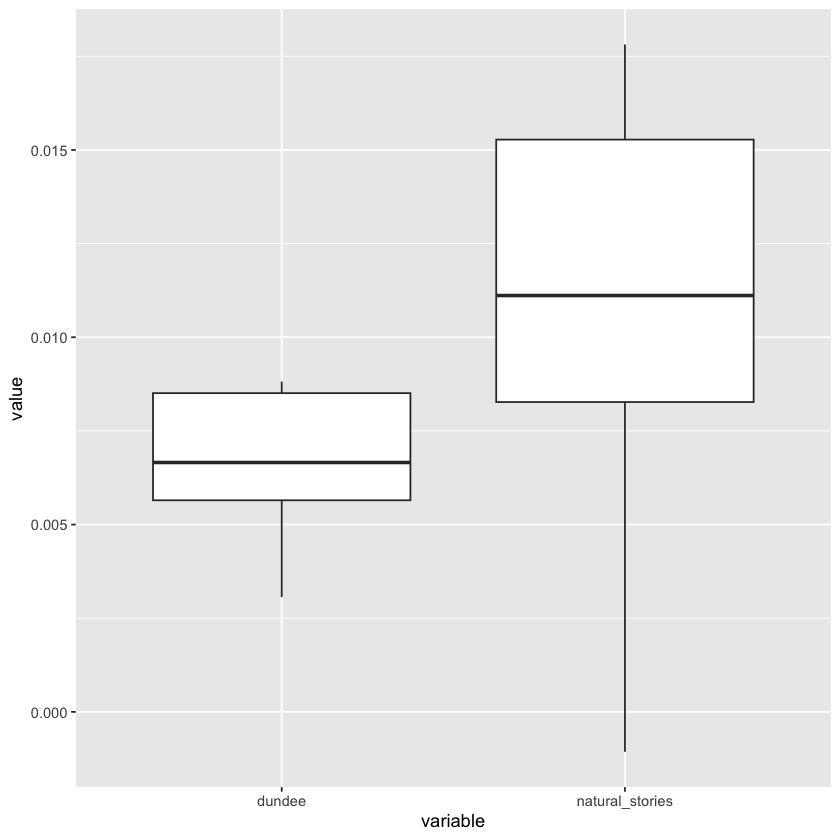

In [38]:
ggplot(cv_results, aes(x=variable, y = value)) + geom_boxplot()